# Extract focal regions from human performance

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from collections import defaultdict

import sys

sys.path.append('../src')

from Config.config import PATHS
from Utils.utils import PPT
from Utils.bar_utils import BarRenderer
from Classes.focal_regions import SetFocalRegions

import warnings
warnings.filterwarnings("ignore")

In [2]:
print("Loading data...")
file_name = PATHS['human_data'] / 'all_data.csv'
data_human = pd.read_csv(file_name)
data_human['model'] = 'human'

# Get the datasets for each treatment
data_downwards = data_human[data_human['treatment'] == 'downwards'].copy()
data_upwards = data_human[data_human['treatment'] == 'upwards'].copy()
dataset_names = ['all', 'downwards', 'upwards']

df_results = pd.DataFrame(columns=[
    'dataset', 'num_agents', 'threshold', 
    'number_focal_schemata', 'number_best_schemata', 'mean_similarity_score'
])


Loading data...


In [ ]:
SIM_THRESHOLD = 0.8

# Iterate over datasets
for idx, data in enumerate([data_human, data_downwards, data_upwards]):

    print(f"Processing dataset {dataset_names[idx]}...")

    list_fixed_parameters = PPT.get_fixed_parameters(data)
    print(f"Number of fixed parameters combinations: {len(list_fixed_parameters)}")

    for i, fixed_parameters in enumerate(list_fixed_parameters):

        if fixed_parameters['num_agents'] not in [3]: continue # Less than 5 agents for now

        row_dataset = dataset_names[idx]

        print(f"Processing fixed parameters ({i}/{len(list_fixed_parameters)}):\n{fixed_parameters}")
        row_num_agents = fixed_parameters['num_agents']
        row_threshold = fixed_parameters['threshold']

        sfr_parameters = {
            'num_agents': fixed_parameters['num_agents'],
            'threshold': fixed_parameters['threshold'],
            'len_history': fixed_parameters['num_agents'],
            'max_regions': 4 * fixed_parameters['num_agents'],  # Arbitrary large number
            'from_file': False
        }

        print(f"\tGenerating focal regions...")
        sfr = SetFocalRegions(**sfr_parameters)
        sfr.generate_focal_regions()
        sfr.focal_regions = list(set(sfr.focal_regions))  # Remove duplicates
        print(f"\tNumber of focal regions: {len(sfr.focal_regions)}")
        row_number_focal_schemata = len(sfr.focal_regions)

        data_session = data_human[
            (data_human['num_players'] == fixed_parameters['num_agents']) &
            (data_human['threshold'] == fixed_parameters['threshold'])
        ].copy()

        best_fitting_regions = []

        for key, grp in data_session.groupby('group'):
            bar_renderer = BarRenderer(data=grp)
            history = np.array(bar_renderer.get_history()).T[:, :20]

            for i, region in enumerate(sfr.focal_regions):
                sim_score = region.get_long_history_similarity_score(history)
                best_fitting_regions.append((i, sim_score))

        best_fitting_regions = pd.DataFrame(best_fitting_regions, columns=['region_id', 'similarity_score'])

        # Get best fitting regions
        focal_regions_ids = best_fitting_regions[best_fitting_regions['similarity_score'] > SIM_THRESHOLD]['region_id'].values
        row_mean_sim_score = best_fitting_regions[best_fitting_regions['similarity_score'] > SIM_THRESHOLD]['similarity_score'].mean()
        focal_regions_ids = list(set(focal_regions_ids))
        focal_regions = [sfr.focal_regions[i] for i in focal_regions_ids]
        sfr.focal_regions = focal_regions

        # Save focal regions
        if idx == 0:  # Only save for the full dataset
            sfr.file = Path('../data/focal_regions') / f"_{sfr.num_agents}_agents_{sfr.threshold}_threshold.npy"
            sfr.save_focal_regions()

        print(f"\tNumber of best fitting regions: {len(focal_regions)}")
        row_number_best_schemata = len(focal_regions)

        df_results.loc[len(df_results)] = [
            row_dataset, row_num_agents, row_threshold, 
            row_number_focal_schemata, row_number_best_schemata, row_mean_sim_score
        ]

    print(f"Finished with dataset {dataset_names[idx]}!")

# df_results.to_csv('focal_schemata_summary.csv', index=False)

### Show results

In [17]:
file_path = PATHS['focal_regions_path'] / 'focal_schemata_summary.csv'
data_summary = pd.read_csv(file_path)
data_summary = data_summary[data_summary['dataset'] != 'all']

# Change round to round within session
dict_num_sessions = {i: 3 for i in range(4, 13)}
dict_num_sessions[2] = 2
dict_num_sessions[3] = 2


group_counter = {grp:0 for grp in data['group'].unique()}
rounds_counter = dict() 
dict_sessions_downwards = defaultdict()
dict_sessions_upwards = defaultdict()
data.sort_values(by=['group', 'treatment', 'threshold'], inplace=True)
for (group, treatment, threshold, num_players), grp in data.groupby(['group', 'treatment', 'threshold', 'num_players']):
    rounds_counter[(group, threshold)] = [grp['round'].min(), grp['round'].max()]
    num_thresholds = dict_num_sessions[num_players]
    if treatment == 'downwards':
        count = num_thresholds - group_counter[group]
        group_counter[group] += 1
        dict_sessions_downwards[(num_players, threshold)] = count
    elif treatment == 'upwards':
        group_counter[group] += 1
        count = group_counter[group]
        dict_sessions_upwards[(num_players, threshold)] = count
    else:
        dict_sessions_downwards[(num_players, threshold)] = 1

dict_sessions = {
    'downwards': dict_sessions_downwards,
    'upwards': dict_sessions_upwards
} 

data_summary['session'] = data_summary.apply(lambda row: dict_sessions[row['dataset']][(row['num_agents'], row['threshold'])], axis=1)

data_summary.head()

,dataset,num_agents,threshold,number_focal_schemata,number_best_schemata,mean_similarity_score,segmented,alternation,mixed,session
27,downwards,4,0.750000,15,0,NaN,0,0,0,1
28,downwards,4,0.500000,16,0,NaN,0,0,0,2
29,downwards,4,0.250000,10,1,1.0,1,0,0,3
30,downwards,3,0.666667,9,0,NaN,0,0,0,1
31,downwards,5,0.800000,19,0,NaN,0,0,0,1


<Axes: xlabel='threshold', ylabel='number_best_schemata'>

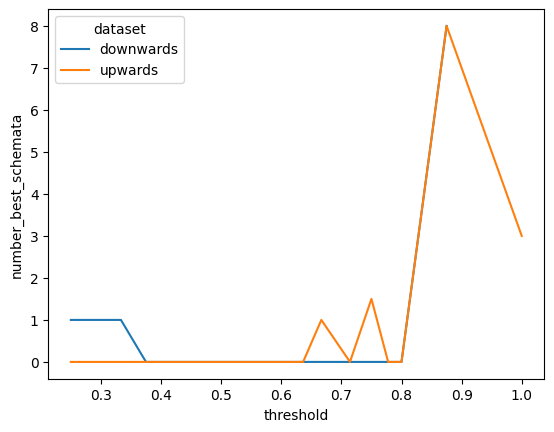

In [18]:
sns.lineplot(
    x='threshold',
    y='number_best_schemata',
    hue='dataset',
    data=data_summary,
    errorbar=None
)

---